In [1]:
from faster_rcnn_datamodule import DataModule
from BoxHead import BoxHead
from utils import non_max_suppression, output_decoding, average_precision
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from torchvision.models.detection.image_list import ImageList

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
keep_topK = 200
keep_num_preNMS = 20

In [4]:
imgs_path = '../partA/data/hw3_mycocodata_img_comp_zlib.h5'
masks_path = '../partA/data/hw3_mycocodata_mask_comp_zlib.h5'
labels_path = '../partA/data/hw3_mycocodata_labels_comp_zlib.npy'
bboxes_path = '../partA/data/hw3_mycocodata_bboxes_comp_zlib.npy'
paths = [imgs_path, masks_path, labels_path, bboxes_path]
datamodule = DataModule(paths) 
     
box_head = BoxHead.load_from_checkpoint('/home/ny0221/cis680/hw4/partB/faster_rcnn/456mwe1b/checkpoints/epoch_29.ckpt')

/home/ny0221/anaconda3/envs/cis680/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ny0221/anaconda3/envs/cis680/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [5]:
datamodule.setup("test")
test_loader = datamodule.test_dataloader()

In [6]:
def get_batch_by_index(test_loader, batch_id):
    test_iterator = iter(test_loader)
    for _ in range(batch_id):
        batch = next(test_iterator)
    return batch

In [7]:
def postprocess_bboxes(img_id, class_logits, box_preds, proposals):
    class_prob = F.softmax(class_logits[img_id], dim=1)
    max_probs, max_classes = torch.max(class_prob[:, 1:], dim=1)
    keep_indices = torch.where(max_probs > 0.5)
    
    start_indices = max_classes[keep_indices] * 4
    range_indices = torch.arange(4).to(start_indices.device)
    start_indices = start_indices.unsqueeze(1)
    indices = start_indices + range_indices
    
    regressed_boxes_t = torch.gather(box_preds[img_id][keep_indices], 1, indices)
    bboxes = output_decoding(regressed_boxes_t, proposals[img_id][keep_indices])

    bboxes = torch.column_stack([max_classes[keep_indices].unsqueeze(1), max_probs[keep_indices].unsqueeze(1), bboxes])
    
    sorted_indices = torch.argsort(bboxes[:, 1], descending=True)
    
    return bboxes[sorted_indices]

In [8]:
def postprocess_img(img_id, class_logits, box_preds, proposals):
    bboxes = postprocess_bboxes(img_id, class_logits, box_preds, proposals)
    pre_nms_bboxes = bboxes[:keep_num_preNMS]
    bboxes = non_max_suppression(pre_nms_bboxes)
    bboxes = bboxes.detach().cpu().numpy()
    pre_nms_bboxes = pre_nms_bboxes.detach().cpu().numpy()
    return pre_nms_bboxes, bboxes

In [9]:
def process_batch(batch):
    imgs, labels, bboxes, indices = batch
    
    imgs = imgs.to(device)
    bboxes = [bbox.to(device) for bbox in bboxes]
    labels = [label.to(device) for label in labels]

    backout = box_head.backbone(imgs)

    im_lis = ImageList(imgs, [(800, 1088)]*imgs.shape[0])
    rpnout = box_head.rpn(im_lis, backout)

    # A list of proposal tensors: list:len(bz){(keep_topK,4)}
    proposals=[proposal[0:keep_topK,:] for proposal in rpnout[0]]
    # A list of features produces by the backbone's FPN levels: list:len(FPN){(bz,256,H_feat,W_feat)}
    fpn_feat_list= list(backout.values())
           
    proposals = box_head.sort_proposals(proposals)
    
    feature_vectors = box_head.MultiScaleRoiAlign(fpn_feat_list,proposals, P=7)
    class_logits, box_preds = box_head(feature_vectors)

    proposal_labels, _ = box_head.create_ground_truth(proposals, labels, bboxes)

    class_logits = class_logits.split(keep_topK)
    box_preds = box_preds.split(keep_topK)

 
    proposal_labels = proposal_labels.split(keep_topK)
    
    return class_logits, box_preds, proposal_labels, proposals

## mAP Scores of the Test Set

In [10]:
all_preds = []
all_targets = []
img_idx = 0
for batch in test_loader:
    imgs, gt_labels, gt_bboxes, indices = batch
    class_logits, box_preds, proposal_labels, proposals = process_batch(batch)
    batch_size = len(imgs)
    for i in range(batch_size): 
        _, preds = postprocess_img(i, class_logits, box_preds, proposals)
        if len(preds) > 0:
            # To compute mean Average Precision (mAP), bounding boxes must be linked to their corresponding images
            # Hence, we append the image index (img_idx) to the predictions (preds) 
            # # The resulting format for each prediction is: (img_idx, class, x1, y1, x2, y2)
            preds = np.column_stack([np.full((len(preds), 1), img_idx), preds])
            all_preds.append(preds)
        if len(gt_bboxes[i]) > 0:
            all_targets.append(np.column_stack([np.full((len(gt_bboxes[i]), 1), img_idx), gt_labels[i].numpy().reshape(-1,1), gt_bboxes[i].numpy()]))
        img_idx += 1

all_preds = np.vstack(all_preds)
all_targets = np.vstack(all_targets)

/home/ny0221/anaconda3/envs/cis680/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/ny0221/anaconda3/envs/cis680/lib/python3.10/site-packages/torch/nn/modules/conv.py:459: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weig

In [18]:
from utils import average_precision
sum_val = average_precision(all_preds, all_targets, 0)+average_precision(all_preds, all_targets, 1)+average_precision(all_preds, all_targets, 2)
mAP = sum_val/3.
print(round(mAP,3))

0.946


In [12]:
def convert_for_visualization(imgs):
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    imgs_for_viz = imgs.numpy()
    imgs_for_viz = np.moveaxis(imgs_for_viz, 1, -1) 
    # denormalize the image
    imgs_for_viz = (imgs_for_viz * std) + mean
    imgs_for_viz = np.clip(imgs_for_viz, 0, 1)
    return imgs_for_viz

In [13]:
batch = get_batch_by_index(test_loader, 8)
imgs, gt_labels, gt_bboxes, indices = batch
class_logits, box_preds, proposal_labels, proposals = process_batch(batch)
imgs_for_viz = convert_for_visualization(imgs)

## Image plots of the proposals with the no-background classes and their ground truth boxes

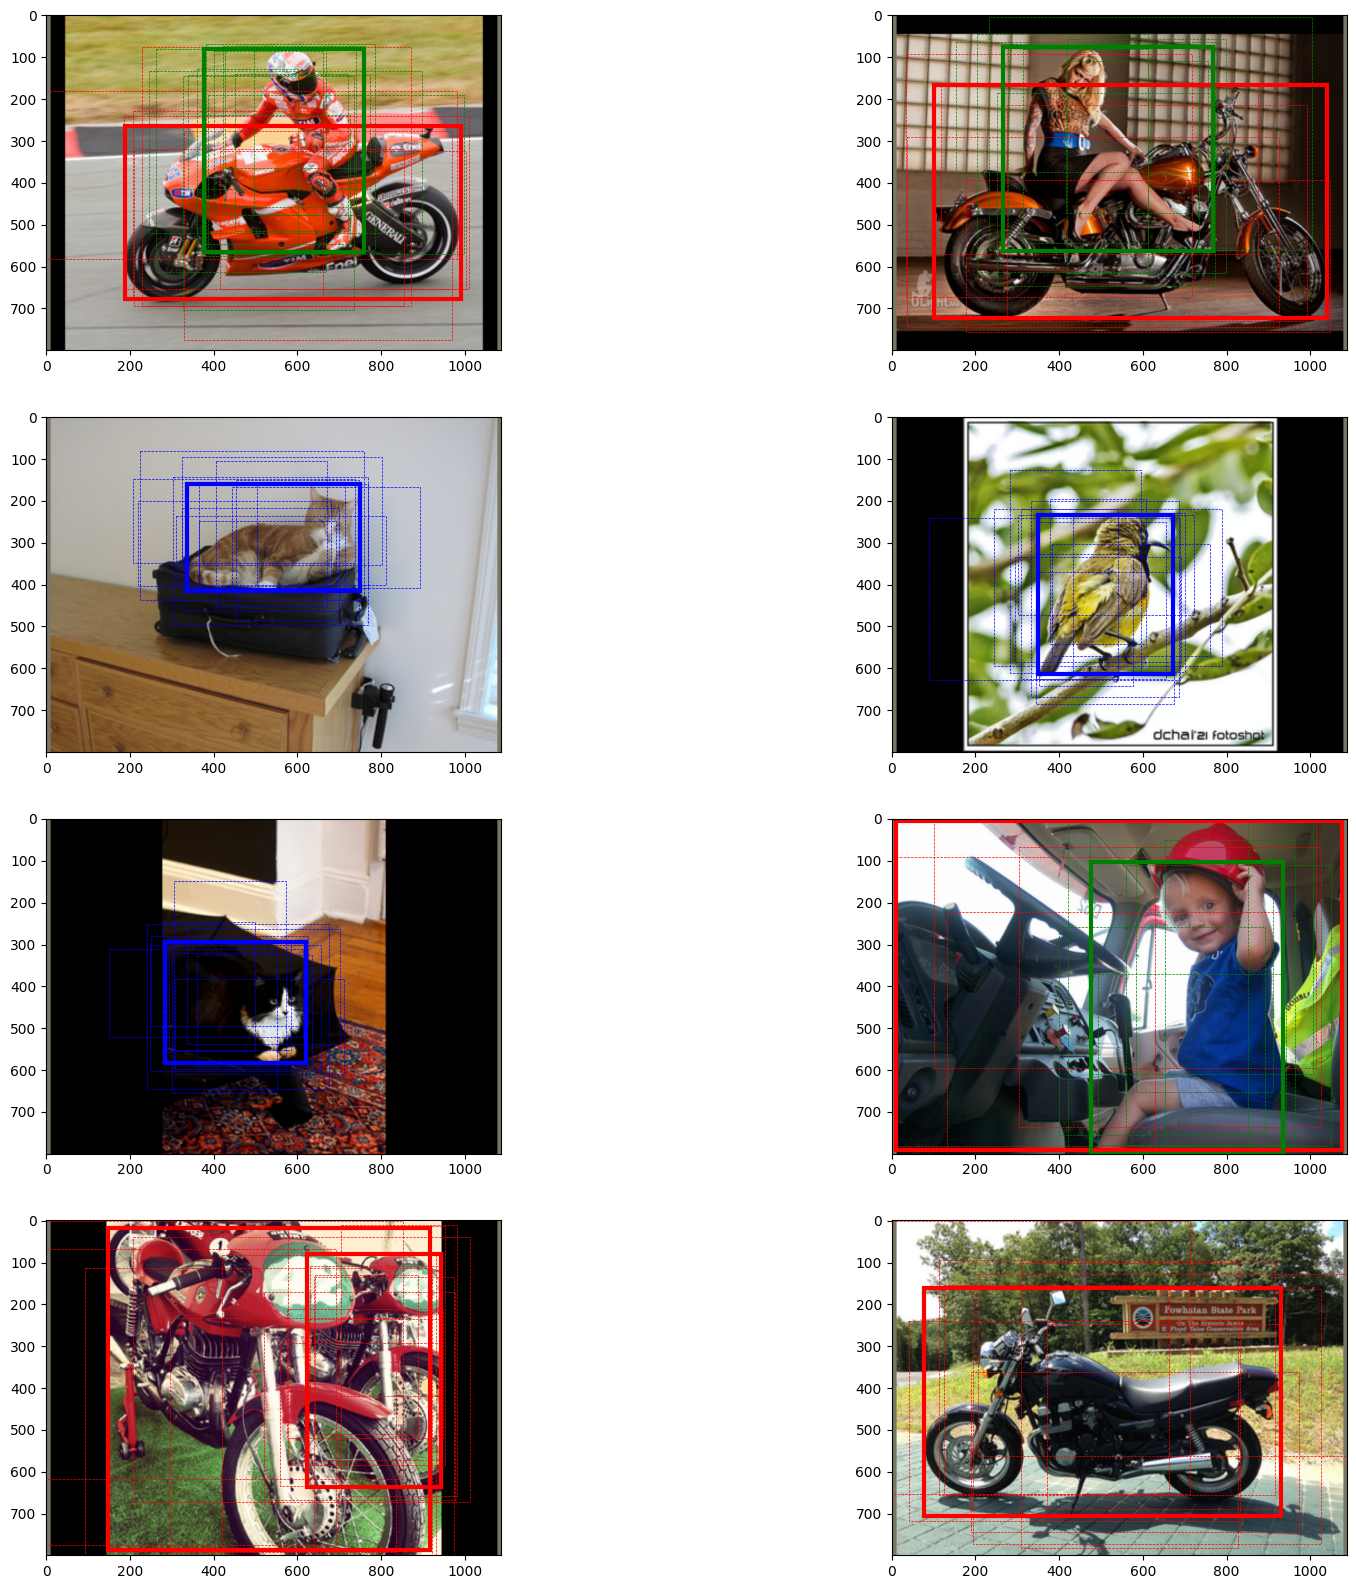

In [14]:
colors = ["red", "green", "blue"]
fig, axes = plt.subplots(4, 2, figsize=(20, 20))

flat_axes = axes.ravel() 

for img_id, ax in enumerate(flat_axes):
    ax.imshow(imgs_for_viz[img_id])
    pos_bboxes_indices = torch.where(proposal_labels[img_id] > 0)[0]
    pos_bboxes = proposals[img_id][pos_bboxes_indices]
    pos_bboxes = pos_bboxes.cpu().numpy()
    classes = proposal_labels[img_id][pos_bboxes_indices]
    
    for i, bbox in enumerate(pos_bboxes):
        cls = classes[i] - 1
        x, y = bbox[0], bbox[1]
        width = bbox[2] - bbox[0]
        height = bbox[3] - bbox[1]
        rect = Rectangle((x, y), width, height, linewidth=0.5, linestyle='dashed', edgecolor=colors[cls], facecolor='none')
        ax.add_patch(rect)
    
    
    for i, bbox in enumerate(gt_bboxes[img_id]):
        cls = gt_labels[img_id][i] - 1
        x, y = bbox[0], bbox[1]
        width = bbox[2] - bbox[0]
        height = bbox[3] - bbox[1]
        rect = Rectangle((x, y), width, height, linewidth=3, edgecolor=colors[cls], facecolor='none')
        ax.add_patch(rect)
        

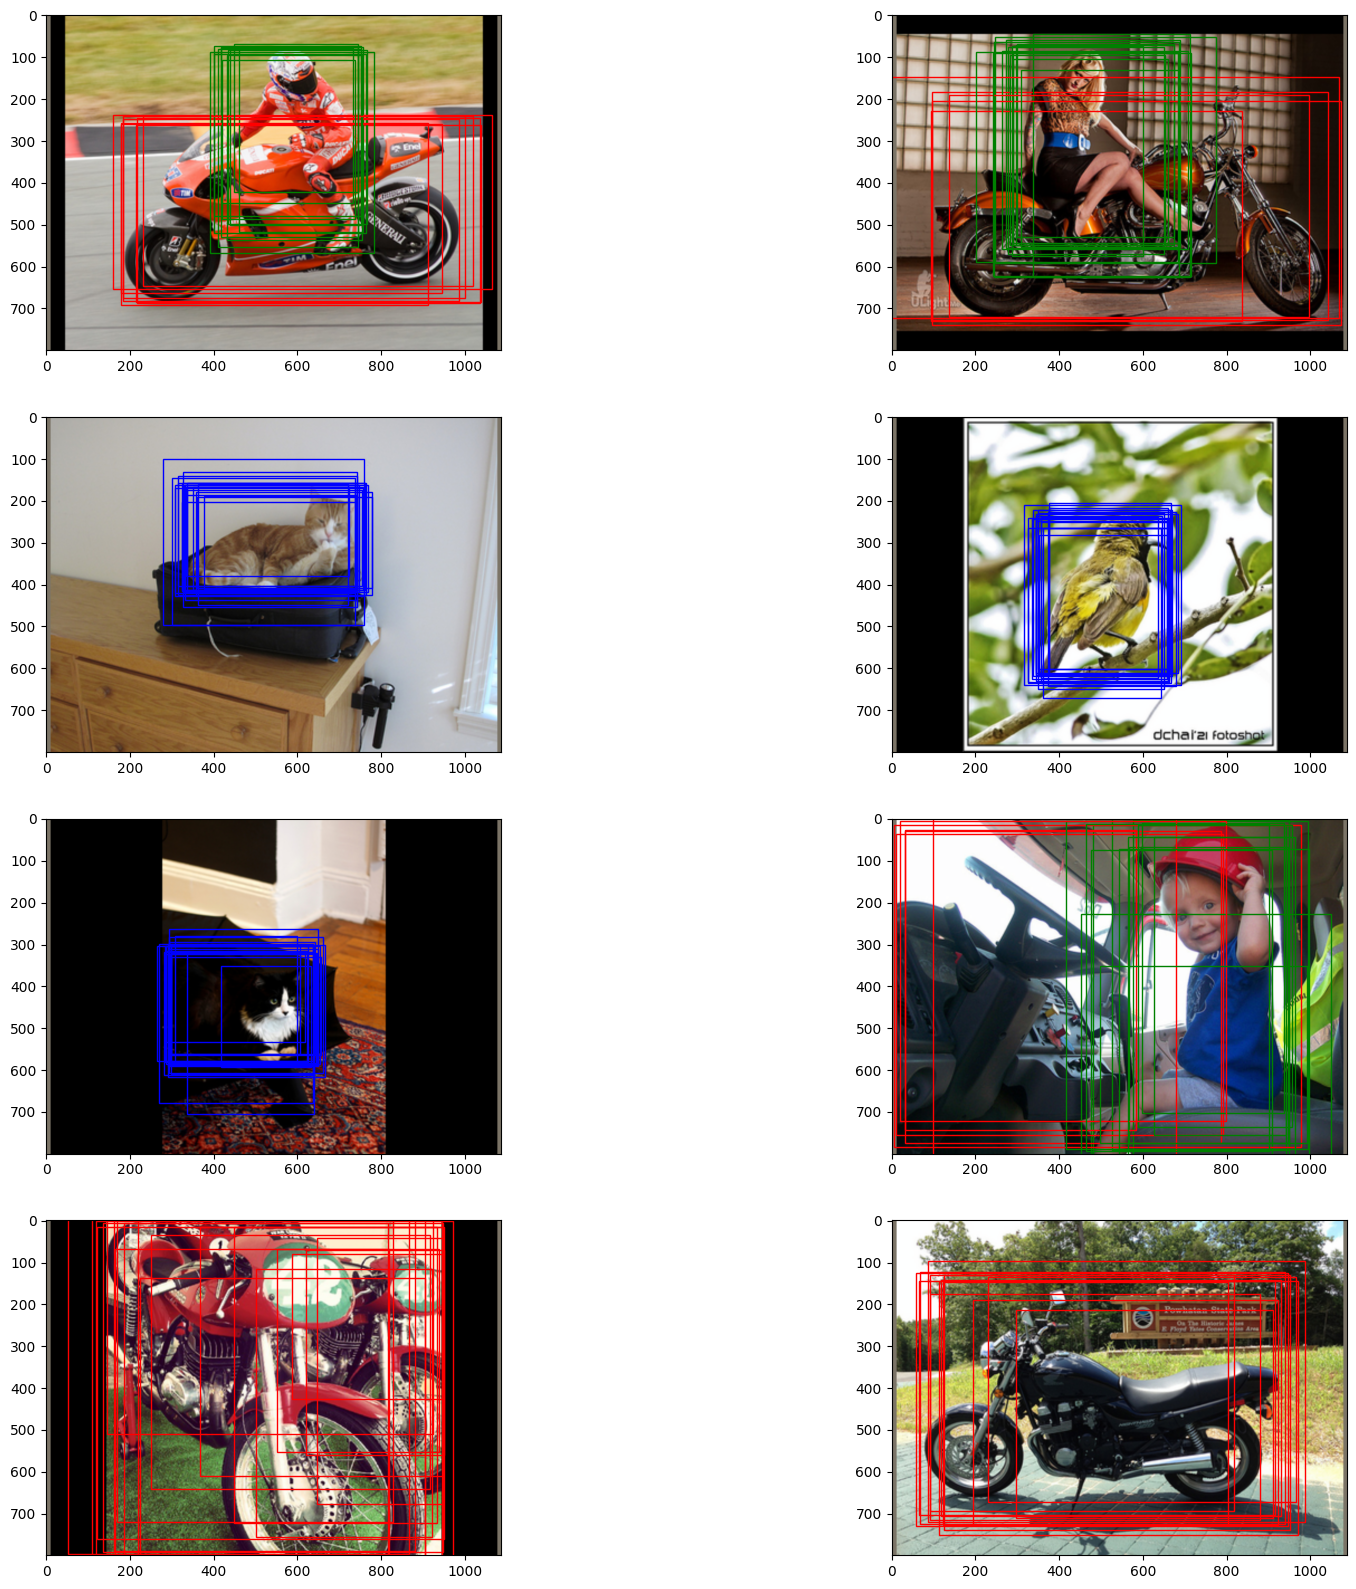

In [15]:
fig, axes = plt.subplots(4, 2, figsize=(20, 20))

flat_axes = axes.ravel() 

for img_id, ax in enumerate(flat_axes):
    ax.imshow(imgs_for_viz[img_id])
    pre_nms_bboxes, _ = postprocess_img(img_id, class_logits, box_preds, proposals)
    for bbox in pre_nms_bboxes:
        clas = int(bbox[0])
        x, y = bbox[2], bbox[3]
        width = bbox[4] - bbox[2]
        height = bbox[5] - bbox[3]
        rect = Rectangle((x, y), width, height, linewidth=1, edgecolor=colors[clas], facecolor='none')
        ax.add_patch(rect)


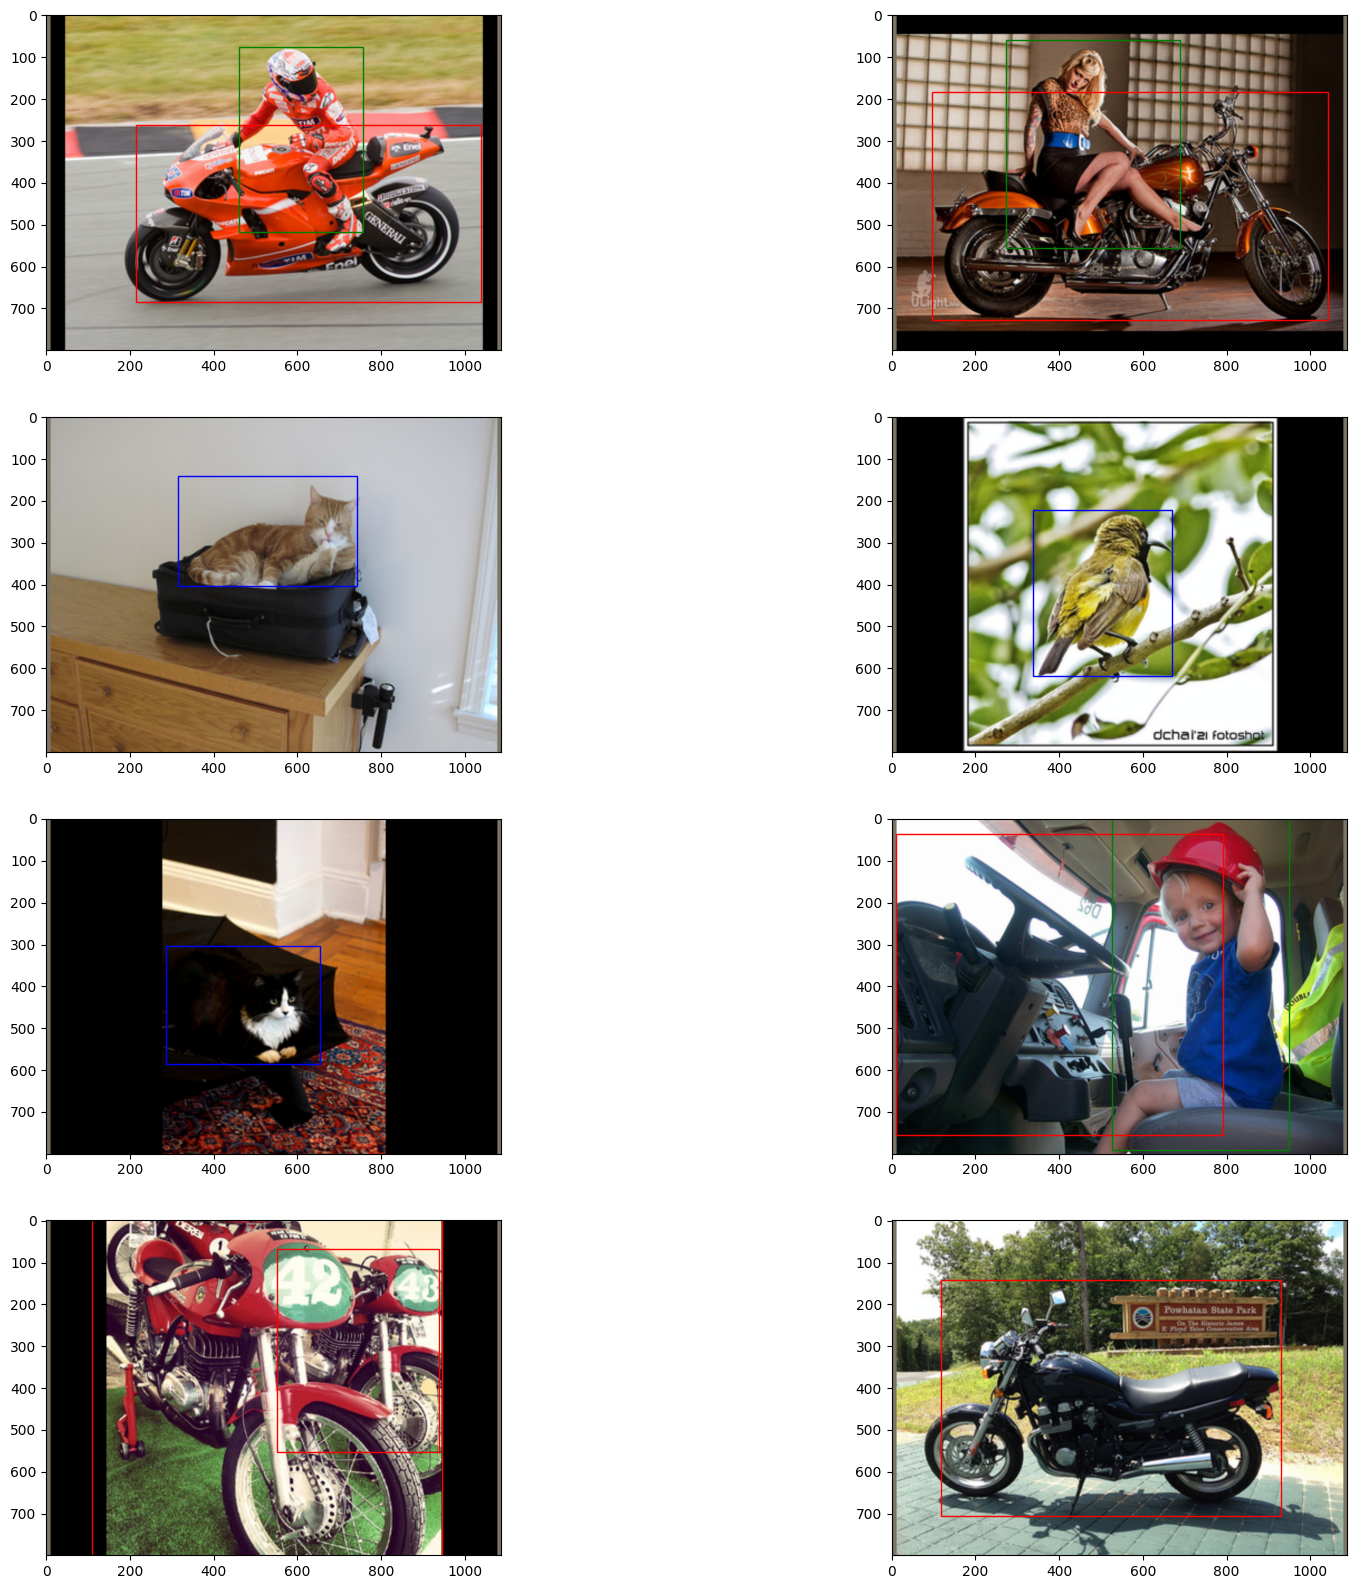

In [16]:
fig, axes = plt.subplots(4, 2, figsize=(20, 20))

flat_axes = axes.ravel() 

for img_id, ax in enumerate(flat_axes):
    ax.imshow(imgs_for_viz[img_id])
    _, bboxes = postprocess_img(img_id, class_logits, box_preds, proposals)
    for bbox in bboxes:
        clas = int(bbox[0])
        x, y = bbox[2], bbox[3]
        width = bbox[4] - bbox[2]
        height = bbox[5] - bbox[3]
        rect = Rectangle((x, y), width, height, linewidth=1, edgecolor=colors[clas], facecolor='none')
        ax.add_patch(rect)


In [20]:
all_preds = []
all_targets = []
img_idx = 0

imgs, gt_labels, gt_bboxes, indices = batch
class_logits, box_preds, proposal_labels, proposals = process_batch(batch)
batch_size = len(imgs)
for i in range(batch_size): 
    _, preds = postprocess_img(i, class_logits, box_preds, proposals)
    if len(preds) > 0:
        preds = np.column_stack([np.full((len(preds), 1), img_idx), preds])
        all_preds.append(preds)
    if len(gt_bboxes[i]) > 0:
        all_targets.append(np.column_stack([np.full((len(gt_bboxes[i]), 1), img_idx), gt_labels[i].numpy().reshape(-1,1), gt_bboxes[i].numpy()]))
    img_idx += 1

all_preds = np.vstack(all_preds)
all_targets = np.vstack(all_targets)

In [ ]:
recalls, precisions = precision_recall_curve(predicted_bboxes, gt_bboxes, 0)
class_name = "Pedestrian" 

plt.figure(figsize=(5, 3))
plt.plot(recalls, precisions, '-o', label=f'Precision-Recall Curve for {class_name}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall Curve for {class_name}')
plt.legend()
plt.grid(True)
plt.xlim([0, 1])
plt.ylim([0, 1.1])
plt.show()